In [1]:
%run code/Limpeza.ipynb

In [2]:
%run code/Representacao.ipynb

In [3]:
%run code/Clusterizacao.ipynb

In [4]:
#-------BASE-------#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
#-------RDKIT WARNINGS-------#
from rdkit import RDLogger
#-------MACHINE LEARNING-------#
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [5]:
# Desabilita os warnings do RDKit
RDLogger.DisableLog('rdApp.*')

***

In [6]:
data = pd.read_csv('data/Acute_Toxicity_mouse_intraperitoneal_LD50.csv')
data.head()

,TAID,Name,IUPAC Name,PubChem CID,Canonical SMILES,InChIKey,Toxicity Value
0,TOX-145,hydroquinone,"benzene-1,4-diol",785,Oc1ccc(O)cc1,QIGBRXMKCJKVMJ-UHFFFAOYSA-N,99.998184
1,TOX-245,thiotepa,tris(aziridin-1-yl)-sulfanylidene-lambda5-phos...,5453,S=P(N1CC1)(N1CC1)N1CC1,FOCVUCIESVLUNU-UHFFFAOYSA-N,10.999767
2,TOX-1273,lindane,"1,2,3,4,5,6-hexachlorocyclohexane",727,ClC1C(Cl)C(Cl)C(Cl)C(Cl)C1Cl,JLYXXMFPNIAWKQ-UHFFFAOYSA-N,124.986246
3,TOX-1279,metformin,"3-(diaminomethylidene)-1,1-dimethylguanidine",4091,CN(C)C(=N)N=C(N)N,XZWYZXLIPXDOLR-UHFFFAOYSA-N,294.797771
4,TOX-1282,CARVACROL,2-methyl-5-propan-2-ylphenol,10364,Cc1ccc(C(C)C)cc1O,RECUKUPTGUEGMW-UHFFFAOYSA-N,73.299512


In [7]:
data = data[['Canonical SMILES', 'Toxicity Value']]
data['log_tox'] = -np.log(data['Toxicity Value'])
data.rename(columns={'Canonical SMILES':'smiles', 'Toxicity Value':'tox'}, inplace=True)

data.head()

,smiles,tox,log_tox
0,Oc1ccc(O)cc1,99.998184,-4.605152
1,S=P(N1CC1)(N1CC1)N1CC1,10.999767,-2.397874
2,ClC1C(Cl)C(Cl)C(Cl)C(Cl)C1Cl,124.986246,-4.828204
3,CN(C)C(=N)N=C(N)N,294.797771,-5.686290
4,Cc1ccc(C(C)C)cc1O,73.299512,-4.294554


### Distribuição

<Axes: >

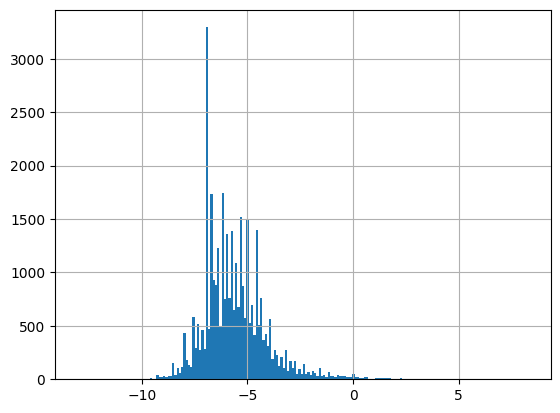

In [8]:
data['log_tox'].hist(bins=200)

In [9]:
# Converter valores da coluna 'valor' para float
data['log_tox'] = pd.to_numeric(data['log_tox'], errors='coerce')

# Remove NaN
data.dropna(subset=['log_tox', 'smiles'], inplace=True, ignore_index=True)

# Realiza a limpeza dos dados
limpeza = Limpeza(dataframe=data)
data = limpeza.dados_limpos(col_smiles='smiles', col_valor='log_tox', sanitize=True, cutoff=.05, fragmento=False)

# Define a representação fingerprint
representacao = Representacao(dataframe=data)
data = representacao.fingerprint(col_smiles='smiles', fingerprint='morgan', use_count=True, fpSize=4096, radius=3)

In [10]:
# Define os conjuntos de treinamento e teste
X = np.array(data['Features'].to_list())
y = data['log_tox'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

***

In [11]:
def ANN(fpSize: int):
    
    # Define o modelo ANN
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(300, activation='relu', input_shape=(fpSize,)),
        tf.keras.layers.Dense(200, activation='relu'),
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    
    return model

In [12]:
# Aplica ANN
model = ANN(fpSize=4096)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
history = model.fit(X_train, y_train, validation_split=0.1, epochs=200, batch_size=32)

Epoch 1/200


C:\Users\berna\anaconda3\envs\portfolio_ml\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


794/794 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 4.2284 - mae: 1.4509 - val_loss: 1.4387 - val_mae: 0.8693
Epoch 2/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.9619 - mae: 0.7036 - val_loss: 1.3176 - val_mae: 0.8166
Epoch 3/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.6374 - mae: 0.5645 - val_loss: 1.3133 - val_mae: 0.8080
Epoch 4/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.4552 - mae: 0.4765 - val_loss: 1.2251 - val_mae: 0.7817
Epoch 5/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.3389 - mae: 0.4092 - val_loss: 1.2354 - val_mae: 0.7655
Epoch 6/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.2749 - mae: 0.3618 - val_loss: 1.2327 - val_mae: 0.7713
Epoch 7/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.2224 - mae: 0.3306 - val_loss: 1.2619 - val_mae: 0.7721
Epoch 8/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.1913 - mae: 0.3057 - val_loss: 1.2846 - val_mae: 0.7798
Epoch 9/200
794/794 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss:

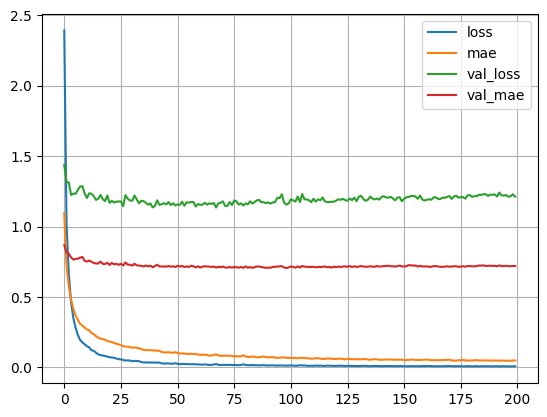

In [13]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.show()

In [14]:
# Obtem as métricas do modelo
loss, mae = model.evaluate(X_test, y_test)

# R-squared
predictions = model.predict(X_test)
y_true = np.array(y_test)
y_pred = np.array(predictions)

r2 = r2_score(y_true, y_pred)

print(f'Loss: {loss}')
print(f'MAE: {mae}')
print(f'R²: {r2}')

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1079 - mae: 0.6770
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Loss: 1.0948057174682617
MAE: 0.6812524199485779
R²: 0.5448203275315517


<function matplotlib.pyplot.show(close=None, block=None)>

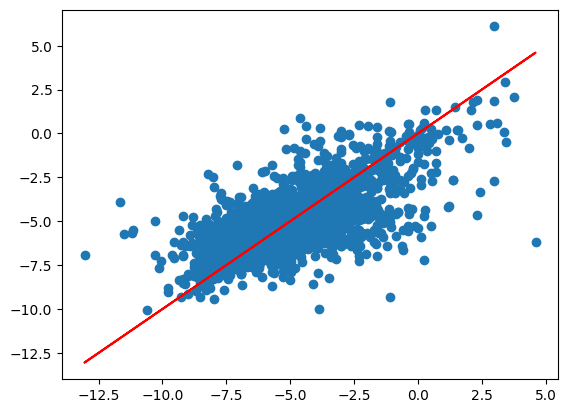

In [15]:
plt.scatter(y_true, y_pred)
plt.plot(y_true, y_true, color='red')
plt.show